## Assignment 6

# Analysis of accuracy decrease of tracking in conditions of biased state noise

**Starodumova P., Antonov A., Babaev N., Krivova V. | Skoltech EDP course by Tatiana Podladchikova, 2020**

**The objective of Assignment 6 is to analyze the sensitivity of estimation results obtained by a Kalman filter that doesn’t take into account bias of state and measurement noise. This will bring about a deeper understanding of main difficulties of practical Kalman filter implementation and skills to overcome these difficulties to get optimal assimilation output.**

In [183]:
# Import libraries

import numpy as np
import matplotlib.pyplot as plt

**Firstly, we generate a true trajectory $x_i$ of an object motion disturbed by normally distributed biased random acceleration (bias of random noise q=0.2):**

In [184]:
def motion(initialX,initialV,initialT,noiseSigma,size):
    x = [initialX]
    v  = [initialV]
    acceleration = 0

    for i in range(1,size):
        x.append(x[i - 1] + v[i - 1]*initialT + acceleration*initialT**2/2)
        acceleration = np.random.normal(0.2, noiseSigma)
        v.append(v[i - 1] + acceleration * initialT)
    return x,v

In [185]:
# Initial conditions, variance of noise, size of trajectory

initialX_1 = 5
initialV_1 = 1
initialT_1 = 1
internalNoiseSigma_1 = 0.2
size_1 = 200
measSigma_2 = 20

**Then, we generate measurements $z_i$ of the coordinate $x_i$:**

In [186]:
def measurements(process,mean,sigma):
    arr = process.copy()
    for i in range(0,len(arr)):
        arr[i] = arr[i] + np.random.normal(mean,sigma)
    return arr

In [187]:
# Define a function for plotting

def showPlease(arr,legend,xlabel,ylabel,title):
    params = {'legend.fontsize': 20,
          'legend.handlelength': 2}
    plt.rcParams.update(params)
    fig, ax = plt.subplots()
    max_len = 0
    for i in arr:
        if(len(i) > max_len):
            max_len = len(i)
    for i in arr:
        if(len(i) == max_len):
            plt.plot(i)
        else:
            plt.plot([j for j in range(max_len - len(i),max_len)],i)
    fig.set_figwidth(15)
    fig.set_figheight(7)
    plt.grid()
    plt.xlabel(xlabel, fontsize = 16)
    plt.ylabel(ylabel, fontsize = 16)
    plt.legend(legend)
    plt.title(title, fontsize = 16);
    plt.show()

**In order to present the system at state space, we define a period T and introduce F - transition matrix that relates $X_i$ and $X_{i-1}$, G - input matrix that determines how random acceleration $a_i$ affects state vector, H - observation matrix:**

In [188]:
T = 1
F = np.matrix([[1,T],
             [0,1]])
G = np.matrix([[T**2/2],
                 [T]])
H = np.matrix([[1,0]])

**The following functions help us develop Kalman filter algorithm.**

In [189]:
# Function which takes a vector as input and returns dafa from a specified axis

def giveElements(vectors,index):
    x = []
    for i in range(0,len(vectors)):
        x.append((vectors[i][index].item(0)))
    return x

In [190]:
# Function which takes two processes as input and returns their combination as a vector

def giveVectors(processX,processV):
    X = []
    lastIndexX = len(processX) - 1
    lastIndexV = len(processV) - 1
    for i in range(0,max(lastIndexX + 1,lastIndexV + 1)):
        x = [[],[]]
        if(lastIndexX < i):
            x[0].append(0)
        else:
            x[0].append(processX[i])
        if(lastIndexV < i):
            x[1].append(0)
        else:
            x[1].append(processV[i])
        X.append(np.matrix((x)))
    return X

**Now, we develop Kalman filter algorithm to estimate state vector $X_i$ (extrapolation and filtration) with given initial filtered estimate X_0 and initial filtration error covariance matrix P_0. The algorithm neglects that it is a case of a BIASED
random acceleration:**

In [191]:
# Initial filtred estimate and initial filtration error covariance matrix

initialKalmanX_3 = np.matrix([[2],
                    [0]])
initialP_3 = np.matrix([[10000,0],
                    [0,10000]])

In [192]:
class KalmanFilter:
    
    def __init__(self,initialX,initialP,measStates,trueTrajectory,typeofProcess,noiseSigma,vectorK,H,
                F,measSigma,G):
        self.trueTrajectory = trueTrajectory.copy()
        self.measTrajectory = giveElements(measStates,0)
        self.kalmanStates = []
        self.listP = []
        self.listK = []
        
        self.measSigma = measSigma
        self.R = self.giveR()
        self.F = F
        self.H = H
        self.G = G
        prevX = initialX.copy()
        prevP = initialP.copy()
        if(len(vectorK)):
            K = vectorK
            for i in range(0,len(measStates)):
                predictedX,predictedP = self.predict(prevX,prevP,self.giveF(i,i - 1),self.giveQ(i,typeofProcess,noiseSigma))
                prevX,prevP = self.filtrate(predictedX,predictedP,K,measStates[i][0],self.giveH(i),self.R)
                self.listP.append(prevP)
                self.kalmanStates.append(prevX)
                self.listK.append(K)
        else:
            for i in range(0,len(measStates)):
                predictedX,predictedP = self.predict(prevX,prevP,self.giveF(i,i - 1),self.giveQ(i,typeofProcess,noiseSigma))
                K = self.giveK(predictedP,self.giveH(i),self.R)
                prevX,prevP = self.filtrate(predictedX,predictedP,K,measStates[i][0],self.giveH(i),self.R)
                self.listP.append(prevP)
                self.kalmanStates.append(prevX)
                self.listK.append(K)
        self.kalmanTrajectory = giveElements(self.kalmanStates,0)
        
    def giveK(self):
        return self.listK.copy()
    
    def extrapolate(self,step):
        predictions = []
        for i in range(step-1,len(self.trueTrajectory)):
            predictions.append((self.giveF(i,i - 1)**(step - 1))*self.kalmanStates[i - step + 1])
        return predictions
    
    def errors(self,listValues):
        start = 0
        errors = []
        if(len(listValues) < len(self.trueTrajectory)):
            start = len(self.trueTrajectory) - len(listValues)
        for i in range(start,len(self.trueTrajectory)):
            errors.append(self.trueTrajectory[i] - listValues[i - start ])
        return errors
    
    def giveQ(self,index,typeOfProcess,noiseSigma):
        G = self.G
        if(typeOfProcess == "det"):
            return 0
        else:
            return G*G.T*(noiseSigma**2)
        
    def giveK(self,predictedP,H,R):
        return predictedP*H.T*(H*predictedP*H.T + R)**(-1)
    
    def giveR(self):
        return self.measSigma**2
    
    def giveH(self,index):
        return self.H
    
    def giveF(self,firstIndex,secondIndex):
        return self.F
    
    def predict(self,prevX,prevP,F,Q):
        x = F*prevX
        P = F*prevP*F.T + Q
        return x,P
    
    def filtrate(self,predictedX,predictedP,K,meas,H,R):
        x = predictedX + K*(meas - H*predictedX)
        KH = K*H
        P = (np.identity(KH.shape[0]) - KH) * predictedP
        return x,P
    
    def givePError(self):
        p = []
        for i in self.listP:
            p.append((i.item(0,0))**0.5)
        return p

In [193]:
# Define a function which runs the algorithm

def createProcessGiveKalman(size,initialX,initialV,initialT,noiseSigma,
                            measSigma,initialKalmanX,initialP,typeOfProcess,vectorK,H,F,G):
    processX,processV = motion(initialX,initialV,initialT,noiseSigma,size)
    meas = measurements(processX,0,measSigma)
    states = giveVectors(meas,[])
    return KalmanFilter(initialKalmanX,initialP,states,processX,typeOfProcess,noiseSigma,vectorK,H,F,measSigma,G)

**As a result, we obtain filtred estimates using Kalman filter and then compare them with the true trajectory and measurements:**

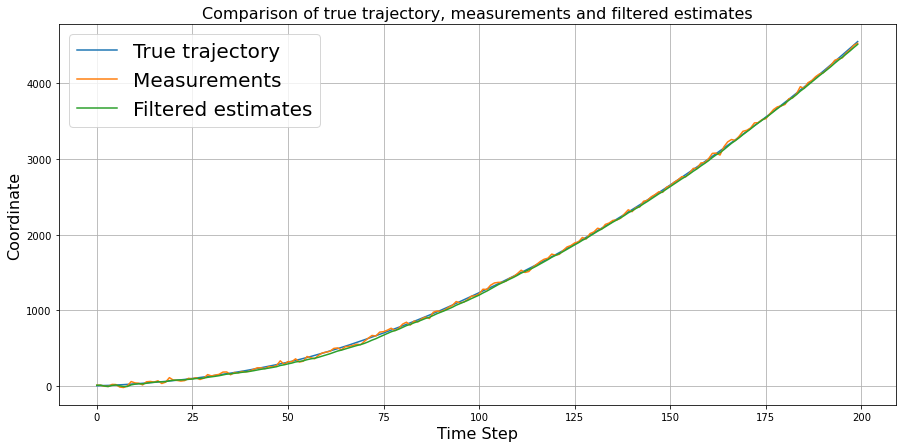

In [194]:
kalmanFilter_1 = createProcessGiveKalman(200,initialX_1,initialV_1,initialT_1,internalNoiseSigma_1,measSigma_2,
                                         initialKalmanX_3,initialP_3,"usual",[],H,F,G)

showPlease([kalmanFilter_1.trueTrajectory,kalmanFilter_1.measTrajectory,kalmanFilter_1.kalmanTrajectory],
           ["True trajectory","Measurements","Filtered estimates"], 'Time Step', 'Сoordinate',
            'Comparison of true trajectory, measurements and filtered estimates')

**Firstly, we noticed that the higher the value of acceleration bias, the higher the estimation of coordinate. It is unclear from the graph whether the algorithm provided us with good filtration, let us take a look a little bit closer:**

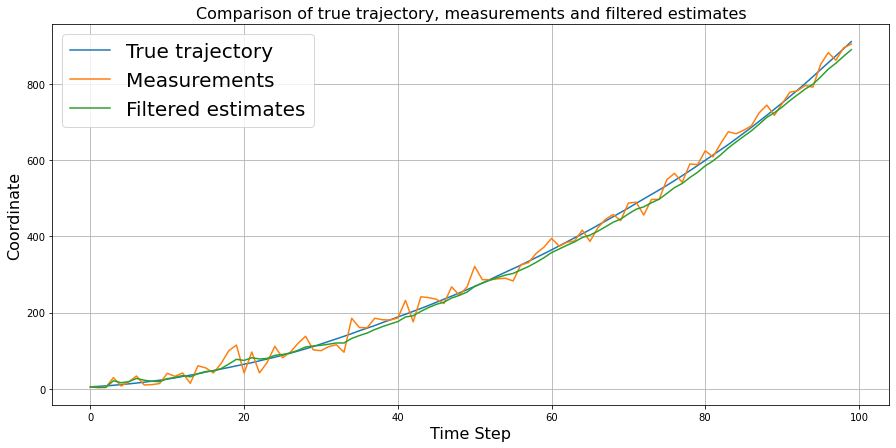

In [195]:
kalmanFilter_1 = createProcessGiveKalman(200, initialX_1,initialV_1,initialT_1,internalNoiseSigma_1,measSigma_2,
                                         initialKalmanX_3,initialP_3,"usual",[],H,F,G)

showPlease([kalmanFilter_1.trueTrajectory[0:100],kalmanFilter_1.measTrajectory[0:100],kalmanFilter_1.kalmanTrajectory[0:100]],
           ["True trajectory","Measurements","Filtered estimates"], 'Time Step', 'Сoordinate',
            'Comparison of true trajectory, measurements and filtered estimates')

**From a closer look on the first 100 time steps, it is seen that filtration at the beginning of observational interval (about 20 steps) described true trajectory more accurately, but then the line of filtered estimates turned out to be at a greater distance from the true trajectory describing its trend correctly but with some error which becomes more or less constant closer to 100 time step.**

**In order to estimate dynamics of mean-squared error of estimation over observation interval, we calculate error for filtered estimate of coordinate $x_{i,i}$:**

In [196]:
def manyKalman(size,amount,initialX,initialV,initialT,noiseSigma,measSigma,
               initialKalmanX,initialP,predictStep,typeOfProcess,vectorK,H,F,G):
    filteredErrorsTotal = [0 for x in range(2,size)]
    predictedErrorsTotal = [0 for x in range(0,size - predictStep + 1)]
    for i in range(0,amount):
        kalman = createProcessGiveKalman(size,initialX,initialV,initialT,noiseSigma,
                            measSigma,initialKalmanX,initialP,typeOfProcess,vectorK,H,F,G)
        filteredErrors = kalman.errors(kalman.kalmanTrajectory)
        predictedErrors = kalman.errors(giveElements(kalman.extrapolate(predictStep),0))
        for j in range(2,size):
            filteredErrorsTotal[j - 2] = filteredErrorsTotal[j - 2] + filteredErrors[j]**2
        for j in range(0,size - predictStep + 1):
            predictedErrorsTotal[j] = predictedErrorsTotal[j] + predictedErrors[j]**2
    for i in range(0,len(filteredErrorsTotal)):
        filteredErrorsTotal[i] = (filteredErrorsTotal[i]/(amount - 1))**0.5
    for i in range(0,size - predictStep + 1):
        predictedErrorsTotal[i] = (predictedErrorsTotal[i]/(amount - 1))**0.5
    return filteredErrorsTotal, predictedErrorsTotal

In [197]:
initialStep_1 = 1

e_filtered_1, _ = manyKalman(200,500,initialX_1,initialV_1,initialT_1,internalNoiseSigma_1,measSigma_2,
                                   initialKalmanX_3,initialP_3,initialStep_1,"ususal",[],H,F,G)

**Now let us compare true estimation error obtained earlier with errors of estimation provided by Kalman filter algorithm:**

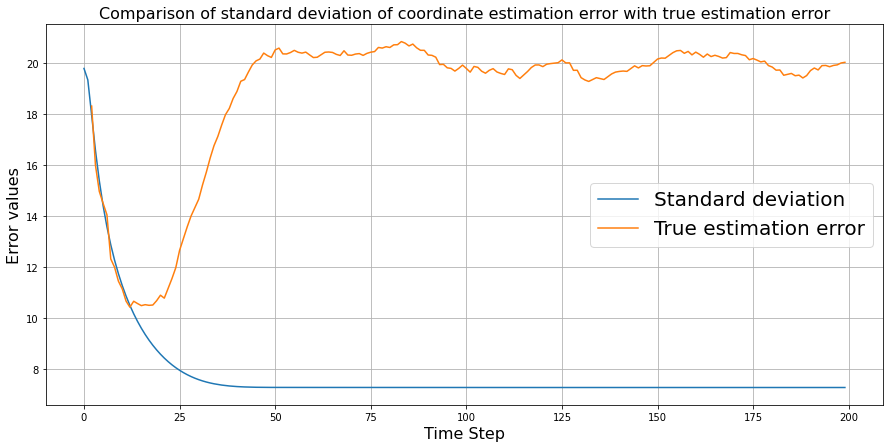

In [198]:
showPlease([kalmanFilter_1.givePError(),e_filtered_1],['Standard deviation', 
                                                          'True estimation error'], 'Time Step', 'Error values', 
           'Comparison of standard deviation of coordinate estimation error with true estimation error')

**True estimation error experiences a sharp drop at first, but then after reaching its minimum it rapidly increases again achieving the level of approximately 20 units. After that, the error remains stable with small fluctuations. It was seen on the graph before when we noticed that the line of foltered estimates keeped a constant distance after app. 25 time steps.** 

**Now we want to develop optimal Kalman filter algorithm that takes into account bias of acceleration. In order to do that, we adjust equation to get the predicted estimate by introducing correction Gq.**

In [199]:
class KalmanFilterOpt:
    
    def __init__(self,initialX,initialP,measStates,trueTrajectory,typeofProcess,noiseSigma,vectorK,H,
                F,measSigma,G):
        self.trueTrajectory = trueTrajectory.copy()
        self.measTrajectory = giveElements(measStates,0)
        self.kalmanStates = []
        self.listP = []
        self.listK = []
        
        self.measSigma = measSigma
        self.R = self.giveR()
        self.F = F
        self.H = H
        self.G = G
        prevX = initialX.copy()
        prevP = initialP.copy()
        if(len(vectorK)):
            K = vectorK
            for i in range(0,len(measStates)):
                predictedX,predictedP = self.predict(prevX,prevP,self.giveF(i,i - 1),self.giveQ(i,typeofProcess,noiseSigma), self.G)
                prevX,prevP = self.filtrate(predictedX,predictedP,K,measStates[i][0],self.giveH(i),self.R)
                self.listP.append(prevP)
                self.kalmanStates.append(prevX)
                self.listK.append(K)
        else:
            for i in range(0,len(measStates)):
                predictedX,predictedP = self.predict(prevX,prevP,self.giveF(i,i - 1),self.giveQ(i,typeofProcess,noiseSigma), self.G)
                K = self.giveK(predictedP,self.giveH(i),self.R)
                prevX,prevP = self.filtrate(predictedX,predictedP,K,measStates[i][0],self.giveH(i),self.R)
                self.listP.append(prevP)
                self.kalmanStates.append(prevX)
                self.listK.append(K)
        self.kalmanTrajectory = giveElements(self.kalmanStates,0)
        
    def giveK(self):
        return self.listK.copy()
    
    def extrapolate(self,step):
        predictions = []
        for i in range(step-1,len(self.trueTrajectory)):
            predictions.append((self.giveF(i,i - 1)**(step - 1))*self.kalmanStates[i - step + 1])
        return predictions
    
    def errors(self,listValues):
        start = 0
        errors = []
        if(len(listValues) < len(self.trueTrajectory)):
            start = len(self.trueTrajectory) - len(listValues)
        for i in range(start,len(self.trueTrajectory)):
            errors.append(self.trueTrajectory[i] - listValues[i - start ])
        return errors
    
    def giveQ(self,index,typeOfProcess,noiseSigma):
        G = self.G
        if(typeOfProcess == "det"):
            return 0
        else:
            return G*G.T*(noiseSigma**2)
        
    def giveK(self,predictedP,H,R):
        return predictedP*H.T*(H*predictedP*H.T + R)**(-1)
    
    def giveR(self):
        return self.measSigma**2
    
    def giveH(self,index):
        return self.H
    
    def giveF(self,firstIndex,secondIndex):
        return self.F
    
    def predict(self,prevX,prevP,F,Q,G):
        q = 0.2
        x = F*prevX + G*q
        P = F*prevP*F.T + Q
        return x,P
    
    def filtrate(self,predictedX,predictedP,K,meas,H,R):
        x = predictedX + K*(meas - H*predictedX)
        KH = K*H
        P = (np.identity(KH.shape[0]) - KH) * predictedP
        return x,P
    
    def givePError(self):
        p = []
        for i in self.listP:
            p.append((i.item(0,0))**0.5)
        return p

In [200]:
def createProcessGiveKalmanOpt(size,initialX,initialV,initialT,noiseSigma,
                            measSigma,initialKalmanX,initialP,typeOfProcess,vectorK,H,F,G):
    processX,processV = motion(initialX,initialV,initialT,noiseSigma,size)
    meas = measurements(processX,0,measSigma)
    states = giveVectors(meas,[])
    return KalmanFilterOpt(initialKalmanX,initialP,states,processX,typeOfProcess,noiseSigma,vectorK,H,F,measSigma,G)

In [201]:
kalmanFilter_1v2 = createProcessGiveKalmanOpt(200,initialX_1,initialV_1,initialT_1,internalNoiseSigma_1,measSigma_2,
                                         initialKalmanX_3,initialP_3,"usual",[],H,F,G)

**We calculate again true estimation errors and errors of estimation P_I provided by optimal Kalman filter and compare them:**

In [202]:
def manyKalmanOpt(size,amount,initialX,initialV,initialT,noiseSigma,measSigma,
               initialKalmanX,initialP,predictStep,typeOfProcess,vectorK,H,F,G):
    filteredErrorsTotal = [0 for x in range(2,size)]
    predictedErrorsTotal = [0 for x in range(0,size - predictStep + 1)]
    for i in range(0,amount):
        kalman = createProcessGiveKalmanOpt(size,initialX,initialV,initialT,noiseSigma,
                            measSigma,initialKalmanX,initialP,typeOfProcess,vectorK,H,F,G)
        filteredErrors = kalman.errors(kalman.kalmanTrajectory)
        predictedErrors = kalman.errors(giveElements(kalman.extrapolate(predictStep),0))
        for j in range(2,size):
            filteredErrorsTotal[j - 2] = filteredErrorsTotal[j - 2] + filteredErrors[j]**2
        for j in range(0,size - predictStep + 1):
            predictedErrorsTotal[j] = predictedErrorsTotal[j] + predictedErrors[j]**2
    for i in range(0,len(filteredErrorsTotal)):
        filteredErrorsTotal[i] = (filteredErrorsTotal[i]/(amount - 1))**0.5
    for i in range(0,size - predictStep + 1):
        predictedErrorsTotal[i] = (predictedErrorsTotal[i]/(amount - 1))**0.5
    return filteredErrorsTotal, predictedErrorsTotal

In [203]:
e_filtered_1v2, _ = manyKalmanOpt(200,500,initialX_1,initialV_1,initialT_1,internalNoiseSigma_1,measSigma_2,
                                   initialKalmanX_3,initialP_3,initialStep_1,"ususal",[],H,F,G)

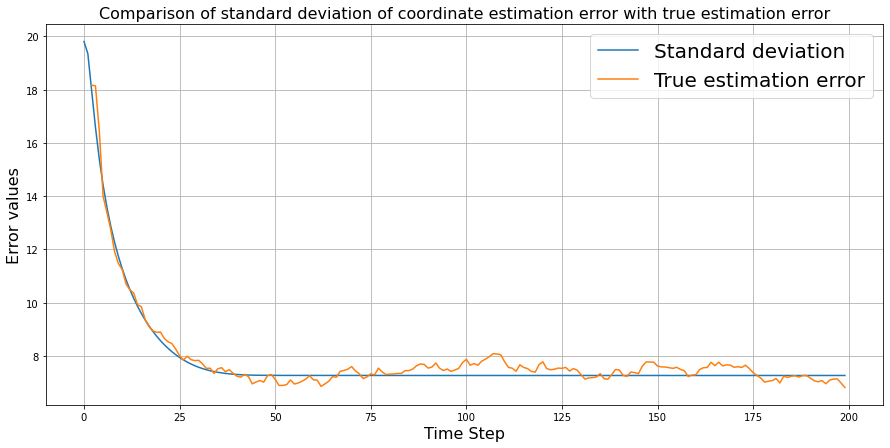

In [204]:
showPlease([kalmanFilter_1v2.givePError(),e_filtered_1v2],['Standard deviation', 
                                                          'True estimation error'], 'Time Step', 'Error values', 
           'Comparison of standard deviation of coordinate estimation error with true estimation error')

**On this graph, calculation errors of estimation correspond to true estimation errors as it should be. It highlights that estimation results obtained by the Kalman filter are sensitive to neglecting bias of state noise. Let us see how the first 100 steps of true trajectory and filtered estimates look now:**

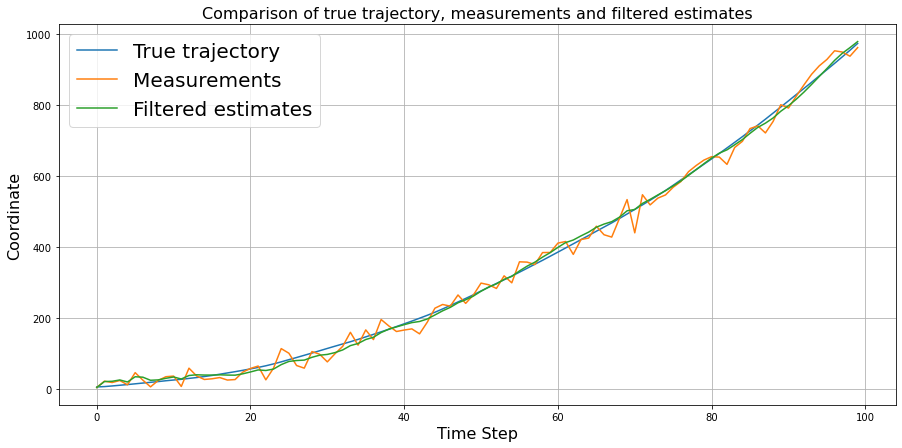

In [205]:
showPlease([kalmanFilter_1v2.trueTrajectory[0:100],kalmanFilter_1v2.measTrajectory[0:100],kalmanFilter_1v2.kalmanTrajectory[0:100]],
           ["True trajectory","Measurements","Filtered estimates"], 'Time Step', 'Сoordinate',
            'Comparison of true trajectory, measurements and filtered estimates')

**The results obtained this time provide a better filtration of measurements. Thus, it is important to use optimised Kalman filter for cases of biased random acceleration.**

**Conclusion: this short assignment introduced us the case of motion with normally distributed biased random acceleration. Firstly, we noticed that even a small bias of mathematical expectation of acceleration leads to a significant increase of coordinate values. It resulted in difficulties with understanding whether the filtration was accurate or not, but after looking closer on the the first half of a 200-point trajectory we noticed some pattern. It was seen that the line of filtered estimates described the first several dozens of time steps more or less accurately but then it stabilised on a certain, almost constant distance and then didn't approach the true trajectory. Calculation of mean-squared error helped us to see how algorithm reacted on this neglection of bias - we realised that the algorithm is not affected by this bias during the first several dozens of prediction steps but then is becomes essential to take it into account. The algorithm do not notice the error as standard deviation provided by itself keeps decreasing and reaching the plateau of a value < 8 but in fact the real error was much greater. Adjustment of the algorithm to the biased acceleration by introducing correction Gq resulted in impoved accuracy of filtered estimates which was seen on both graphs - with errors and trajectories. The outcome of this assignment is clear - optimization of Kalman algorithm is essential in case of such features of trajectories as a biased acceleration so that we obtain optimal assimilation output.**